In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from paths import paths

In [2]:
df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]
print(f"Train cataframe shape is: {df.shape}")
print(f"Labels: {list(label_cols)}")
df.head()
number_experts = df[label_cols].sum(axis = 1)
for label in label_cols:
    df[label] = df[label] / number_experts
display(df)

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
print(len(df.loc[df['eeg_label_offset_seconds'] == 0]))
print(len(df['eeg_id'].unique()))

17089
17089


Every eeg_id has a labeled recording with zero offset.

In [18]:
from numpy.fft import rfft

def generalized(eeg):
    left = None
    right = None
    for key in paths.LABEL_SIDES.keys():
        key_array = np.array(eeg[key]).reshape(-1,)
        P = np.abs(rfft(key_array))
        if paths.LABEL_SIDES[key] == 'left':
            if left is None:
                left = P
            else: left += P
        elif paths.LABEL_SIDES[key] == 'right':
            if right is None:
                right = P
            else: right += P

    hz = 200
    left = np.array(left[int(1.5 * hz):])
    right = np.array(right[int(1.5 * hz):])

    argmax = np.argmax(left + right)

    #plt.plot(left)
    #plt.plot(right)
    #plt.show()

    #score = np.mean((left - right)**2 / (left + right)**2)
    score = sum([(left[argmax + i] - right[argmax + i])**2 / (left[argmax + i] + right[argmax + i])**2 for i in range(-2, 3)])
    return -np.log(score)

  0%|          | 0/11673 [00:00<?, ?it/s]

  4%|▍         | 200/5062 [00:06<02:47, 29.03it/s]


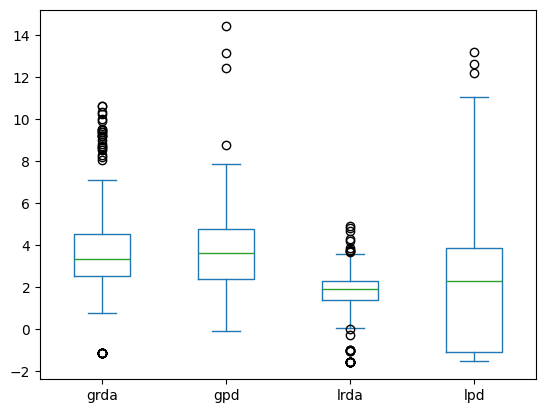

,grda,gpd,lrda,lpd
count,197.000000,200.000000,195.000000,200.000000
mean,3.787476,3.691497,1.636481,2.220688
std,2.607063,2.006671,1.352984,3.136567
min,-1.125209,-0.094495,-1.588349,-1.539006
25%,2.526769,2.410430,1.367933,-1.096198
50%,3.338252,3.642671,1.901359,2.299687
75%,4.517280,4.789018,2.274083,3.882753
max,10.642983,14.424016,4.896479,13.219656


In [20]:
names = ['grda', 'gpd', 'lrda', 'lpd']

scores_by_name = pd.DataFrame()

for name in names:
    sure_df = df.loc[df[f'{name}_vote']==1]
    cl_scores_20 = []
    for i, idx in enumerate(tqdm(sure_df.index)):
        if i > 199: break

        row = sure_df.loc[idx]
        eeg_offset = int(row.eeg_label_offset_seconds)

        cl_eeg_df = pd.read_parquet(paths.TRAIN_EEGS + str(row.eeg_id) + '.parquet')
        #cl_eeg_df = pd.DataFrame(np.load(paths.TRAIN_CLEAN_20 + str(row.eeg_id) + '.npy'))
        cl_eeg_df.columns = paths.EEG_LABELS
        cl_eeg = cl_eeg_df.iloc[(eeg_offset + 20)*200 : min((eeg_offset + 30)*200, cl_eeg_df.shape[0])]
        cl_scores_20.append(generalized(cl_eeg))
        
    scores_by_name[name] = cl_scores_20

stats = scores_by_name.describe()
scores_by_name.plot.box()
plt.show()
display(stats)

  3%|▎         | 501/18245 [00:15<09:05, 32.55it/s]


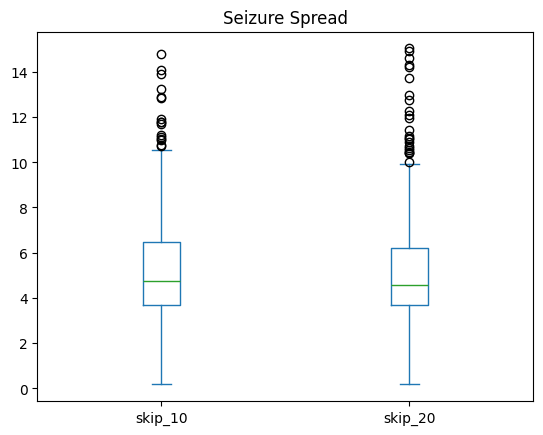

,skip_10,skip_20
count,501.000000,501.000000
mean,5.106143,4.963651
std,2.533068,2.563835
min,0.171484,0.182021
25%,3.664725,3.698417
50%,4.763990,4.585933
75%,6.467864,6.188642
max,14.806990,15.045231


In [8]:
seizure_sure = df.loc[df['seizure_vote'] == 1]

scores = pd.DataFrame()

cl_scores_10 = []
cl_scores_20 = []
for i, idx in enumerate(tqdm(seizure_sure.index)):
    if i > 500:
        break
    row = seizure_sure.loc[idx]
    eeg_offset = int(row.eeg_label_offset_seconds)

    cl_eeg_df = pd.DataFrame(np.load(paths.TRAIN_CLEAN_10 + str(row.eeg_id) + '.npy'))
    cl_eeg_df.columns = paths.EEG_LABELS
    cl_eeg = cl_eeg_df.iloc[(eeg_offset + 10)*20 : min((eeg_offset + 40)*20, cl_eeg_df.shape[0])]
    cl_score_10 = generalized(cl_eeg)
    cl_scores_10.append(-np.log(cl_score_10))

    cl_eeg_df = pd.DataFrame(np.load(paths.TRAIN_CLEAN_20 + str(row.eeg_id) + '.npy'))
    cl_eeg_df.columns = paths.EEG_LABELS
    cl_eeg = cl_eeg_df.iloc[(eeg_offset + 10)*10 : min((eeg_offset + 40)*10, cl_eeg_df.shape[0])]
    cl_score_20 = generalized(cl_eeg)
    cl_scores_20.append(-np.log(cl_score_20))
        
scores['skip_10'] = cl_scores_10
scores['skip_20'] = cl_scores_20

stats = scores.describe()
scores.plot.box()
plt.title('Seizure Spread')
plt.show()
display(stats)

Smoothed Data clearly better for differentiating generalized vs lateral.

I think the approach is simply to measure PD and RDA scores on each side and then bring results together to determine G / L.

In [56]:
from numpy.fft import rfft

def discharge(eeg):
    summer = None
    for key in paths.LABEL_SIDES.keys():
        if paths.LABEL_SIDES[key] == 'left' or paths.LABEL_SIDES[key] == 'right':
            key_array = np.array(eeg[key]).reshape(-1,)
            P = np.abs(rfft(key_array))
            if summer is None:
                summer = P
            else: summer += P

    hz = 200
    cutoff = int(0.5 * hz)
    all = np.array(summer[cutoff:])
    #plt.plot(all)
    #plt.show()

    pows = np.power(all, 2)

    lower_end = int(1.5 * hz) - cutoff
    score = np.sum(pows[:lower_end]) / np.sum(pows)
    return np.log(score / (1 - score)) # logit

 17%|█▋        | 3000/17224 [00:24<01:57, 120.79it/s]


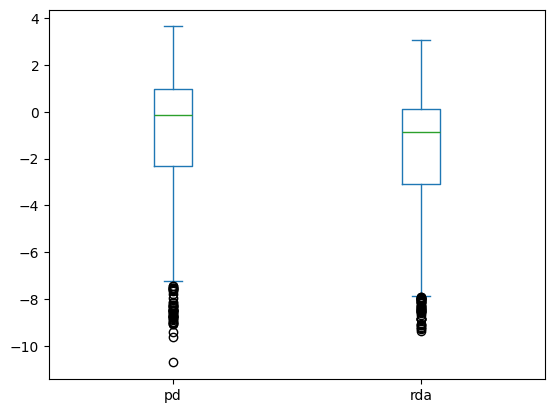

,pd,rda
count,2985.000000,2979.000000
mean,-0.752489,-1.535401
std,2.436257,2.439875
min,-10.711989,-9.369998
25%,-2.313611,-3.082721
50%,-0.124545,-0.849350
75%,0.973008,0.123326
max,3.651124,3.091213


In [57]:
names = ['pd', 'rda']

scores_by_name = pd.DataFrame()

for name in names:
    g_sure_rows = df[f'g{name}_vote'] == 1
    l_sure_rows = df[f'l{name}_vote'] == 1
    sure_rows = pd.Series([g_sure_rows[i] or l_sure_rows[i] for i in range(len(g_sure_rows))])

    sure_df = df.loc[sure_rows]
    cl_scores = []
    for i, idx in enumerate(tqdm(sure_df.index)):
        if i > 2999: break

        row = sure_df.loc[idx]
        eeg_offset = int(row.eeg_label_offset_seconds)

        cl_eeg_df = pd.read_parquet(paths.TRAIN_EEGS + str(row.eeg_id) + '.parquet')
        cl_eeg = cl_eeg_df.iloc[(eeg_offset + 20)*200 : min((eeg_offset + 30)*200, cl_eeg_df.shape[0])]
        cl_scores.append(discharge(cl_eeg))
        
    scores_by_name[name] = cl_scores

stats = scores_by_name.describe()
scores_by_name.plot.box()
plt.show()
display(stats)

## 2/7 Smoothing EEGs

In [13]:
grda_df = df.loc[df['grda_vote']==1][['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds']]
display(grda_df)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds
58,8071080,0,0.0
59,8071080,1,10.0
60,8071080,2,14.0
61,8071080,3,18.0
86,2978448322,0,0.0
...,...,...,...
106726,1142142950,2,18.0
106727,1142142950,3,24.0
106728,1142142950,4,30.0
106729,1142142950,5,34.0


## Creating 'Generalized' Folder

In [19]:
from joblib import Parallel, delayed
import json

In [42]:
df = pd.read_csv(paths.TRAIN_CSV)[['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds']]
def generalizer(rownum, big_dict, skip=20):
    row = df.loc[rownum]
    id = str(int(row.eeg_id))
    sub_id = str(int(row.eeg_sub_id))
    eeg_offset = int(row.eeg_label_offset_seconds)

    if skip == 5:
        eeg = pd.DataFrame(np.load(paths.TRAIN_CLEAN_5 + id + '.npy'))
    elif skip == 10:
        eeg = pd.DataFrame(np.load(paths.TRAIN_CLEAN_10 + id + '.npy'))
    elif skip == 20:
        eeg = pd.DataFrame(np.load(paths.TRAIN_CLEAN_20 + id + '.npy'))
    else: return
    eeg.columns = paths.EEG_LABELS
    
    multiple = 200/skip
    cut_eeg = eeg.iloc[int((eeg_offset + 15)*multiple) : int(min((eeg_offset + 35)*multiple, eeg.shape[0]))]
    score = -np.log(generalized(cut_eeg))
    
    big_dict[f'{id}_{sub_id}'] = score

skip_value = 5
big_dict = {}
for rownum in tqdm(df.index):
    generalizer(rownum, big_dict, skip_value)
with open(f"generalized_{skip_value}.json", "w") as outfile:
    json.dump(big_dict, outfile)